In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

import os
import urllib.request
import tarfile
import pickle
import struct

from utils import buildNetwork, load_cifar,download_cifar

# URL for the data-set on the internet.
data_path = "data/CIFAR-10/"
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

In [2]:
# Let's start a Session
sess = tf.Session()

## Download CIFAR-10 (only needs to be run once)

In [3]:
download_cifar(data_path, data_url)

KeyboardInterrupt: 

## Loading CIFAR-10 into memory

In [3]:
train_samples, train_labels, val_samples, val_labels = load_cifar(data_path)

## Task: Use matplotlib to plot 5 random *training* samples and print the corresponding class label

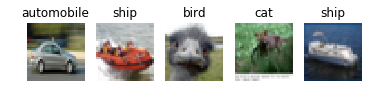

In [4]:
label_to_name = ['airplane', 'automobile', 'bird', 'cat', 'deer' , 'dog', 'frog', 'horse', 'ship', 'truck']

# TODO plot 5 training samples
#print (train_samples.shape[0])
indexes=np.random.choice(train_samples.shape[0], 5, replace=False)
#print (indexes.shape[0])
for ite, index in enumerate(indexes):    
    plt.subplot(2, 5, ite+1)
    plt.title(label_to_name[train_labels[index]])
    plt.imshow(train_samples[index])
    plt.axis('off')

## Building Tensorflow Graph

In [5]:
HEIGHT = 32
WIDTH = 32
CHANNELS = 3
NUM_CLASSES = 10

# You can also modify these hyper-parameters (batch_size, epochs)
# e.g. Add more epochs, if not converged. Reduce batch_size if too big for your GPU memory
batch_size = 50
num_train_epochs = 10
drop_rate_val=0.75
steps_per_epoch = (int)(train_samples.shape[0] / batch_size)

#Convert to one hot encoding
dataset_size=train_labels.shape[0]
train_labels_one_hot=np.zeros((train_labels.shape[0], NUM_CLASSES))
train_labels_one_hot[np.arange(dataset_size), train_labels]=1
#print(train_labels_one_hot)
#print(train_labels_one_hot.shape)


val_size=val_labels.shape[0]
val_labels_one_hot=np.zeros((val_size, NUM_CLASSES))
val_labels_one_hot[np.arange(val_size), val_labels]=1
#print(val_labels_one_hot)
#print(val_labels_one_hot.shape)

In [6]:
# TODO define placeholders for the inputs and their labels (hint: what is their type, shape?)

inputs = tf.placeholder(tf.float32, [batch_size, HEIGHT, WIDTH, CHANNELS])
labels = tf.placeholder(tf.int32, [batch_size, NUM_CLASSES])
drop_rate = tf.placeholder(tf.float32)

logits = buildNetwork(inputs, batch_size, drop_rate)
#print (logits.shape)

xxxxxxxxxxxxxxx
(50, 32, 32, 3)
3
64
32
Linear Layer
(50, 1024)
Linear Layer
(50, 384)
Linear Layer
(50, 192)


## Task: Build the Loss. Add weight regularization.

In [7]:
# TODO add an appropriate cross entropy loss function
cost = (tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
# TODO use reduce_mean to combine the single loss values from all the different input samples
mean_cost=tf.reduce_mean(cost)
# TODO add L2 regularization

#check number of parameters
#total_parameters = 0
# for variable in tf.trainable_variables():
#     # shape is an array of tf.Dimension
#     shape = variable.get_shape()
#     print(shape)
#     print(len(shape))
#     variable_parametes = 1
#     for dim in shape:
#         variable_parametes *= dim.value
#     print(variable_parametes)
#     total_parameters += variable_parametes
# print(total_parameters)


tvars=tf.trainable_variables()
l2_reg = tf.reduce_sum([tf.nn.l2_loss(var) for var in tvars])
loss = (mean_cost + 1e-4* l2_reg)

# hint: use tf.trainable_variables() and tf.nn.l2_loss(var)

In [8]:
# Compute accuracy as an evaluation metric
predictions = tf.to_int32(tf.argmax(logits, axis=1))
correct_mask = tf.to_float(tf.equal(predictions, tf.to_int32(tf.argmax(labels, axis=1))))
accuracy = tf.reduce_mean(correct_mask)

## Task: Define Learning Rate, Optimizer and Training Operation

In [9]:
global_step = tf.Variable(0, name='global_step', trainable=False) 

# TODO define the learning rate
learn_rate = tf.Variable(0.001, tf.float32)
# TODO define the optimizer (experiment with different options)
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate)
# TODO build the corresponding training operation
train = optimizer.minimize(loss, global_step=global_step)

In [10]:
# Define summary operations. Note, that the names may vary depending on how you defined variables!

train_summaries = [
  tf.summary.scalar('train_loss', loss),
  tf.summary.scalar('train_accuracy', accuracy)
]
train_summary_op = tf.summary.merge(train_summaries)

val_accuracy = tf.placeholder(tf.float32)
val_summary_op = tf.summary.scalar('val_accuracy', val_accuracy)

# Define a single summary writer, which will take care of writing
# our summary representations to disk.
writer = tf.summary.FileWriter('log')

## Task: Initialize the variables

In [11]:
# TODO use the variables initializer to build the operation and run it in the current session (named sess)
init = tf.global_variables_initializer()
sess.run(init)

##  Task: Train your network. Display the progress. 

In [12]:
saver=tf.train.Saver()
# indicators on how often to create a summary
num_steps_per_train_summary = 25  

# TODO run num_train_steps iterations on the training samples each of batchsize 50
for epoch in range(num_train_epochs):
    
    # TODO randomly shuffle training samples
    train_sample_size=train_samples.shape[0]
    indexes=np.arange(train_sample_size)
    np.random.shuffle(indexes)
    train_samples=train_samples[indexes, :, :, :]
    train_labels_one_hot=train_labels_one_hot[indexes, :]
    for iter in range(steps_per_epoch):
        # TODO read the batch and execute one iteration of the graph 
        t=iter*batch_size
        inputs1 = train_samples[t:t+batch_size]
        inputs1=inputs1.astype(np.float32)

        labels1 = train_labels_one_hot[t:t+batch_size]
        labels1=labels1.astype(np.int32)
         #Check if inputs are read correctly   
#         indexes=np.random.choice(inputs1.shape[0], 5, replace=False)
#         print (indexes.shape[0])
#         for ite, index in enumerate(indexes):
#             print(labels1[index])
#         for ite, index in enumerate(indexes): 
#             plt.subplot(2, 5, ite+1)
#             plt.imshow(inputs1[index])
#             plt.axis('off') 
#         break

        feed_dict_train = {inputs:inputs1,
                           labels: labels1, drop_rate:drop_rate_val}

        i_global,entloss, acc, _ = sess.run([global_step,loss,accuracy,train], feed_dict=feed_dict_train)
        
        
        # TODO every num_steps_per_train_summary iterations: 
        #     save the current training status (loss and accuracy) to tensorboard
     
        if(iter%num_steps_per_train_summary==0):
            #print(entloss)
            print(acc)
            #print(np.sum(sess.run(correct_mask, feed_dict=feed_dict_train)))
            summary=sess.run(train_summary_op, feed_dict=feed_dict_train)
            writer.add_summary(summary, i_global)

     
    # TODO every epoch: 
    #     save the current validation accuracy to tensorboard
    # Note: we are interested in the accuracy over the *entire* validation set, not just the current batch
    
    val_data_per_epoch=(int)(val_samples.shape[0]/batch_size)
    #keep a count of number of images predicted correctly in the whole validation set
    numCorrectLabels=0
    for i in range(val_data_per_epoch):
        t_val=i*batch_size
        
        #Select the next batch_size inputs from validation set
        inputs_val = val_samples[t_val:t_val+batch_size]
        inputs_val=inputs_val.astype(np.float32)

        labels_val_enc = val_labels_one_hot[t_val:t_val+batch_size]
        labels_val_enc=labels_val_enc.astype(np.int32)
       
        #drop_rate 1 for validation
        feed_dict_val = {inputs:inputs_val,
                           labels: labels_val_enc, drop_rate:1} 
        #number of images predicted correctly 
        sum=np.sum(sess.run(correct_mask, feed_dict=feed_dict_val))
        numCorrectLabels+=sum
      
    print("Validation accuracy: ") 
    #no of samples predicted correctly in the whole set/total number of images
    value_accuracy=numCorrectLabels/val_samples.shape[0]
    print(value_accuracy)
    #val_summary=sess.run(val_summary_op, feed_dict={inputs:inputs_val,labels: labels_val_enc, val_accuracy:value_accuracy})
    #writer.add_summary(val_summary, i_global)
    #saver.save(sess, 'checkpoints/model.ckpt')
    saver.save(sess, 'checkpoints/model.ckpt')

0.06
0.18
0.16
0.24
0.2
0.28
0.28
0.36
0.32
0.26
0.26
0.38
0.42
0.44
0.36
0.4
0.44
0.46
0.6
0.44
0.48
0.5
0.44
0.52
0.54
0.36
0.5
0.46
0.42
0.6
0.58
0.4
0.52
0.5
0.62
0.52
0.46
0.62
0.36
0.56
Validation accuracy: 
Tensor("Placeholder_3:0", dtype=float32)
0.44
0.58
0.46
0.46
0.46
0.6
0.52
0.54
0.52
0.46
0.64
0.44
0.42
0.48
0.6
0.52
0.68
0.6
0.58
0.46
0.42
0.66
0.48
0.52
0.46
0.46
0.52
0.54
0.46
0.6


KeyboardInterrupt: 

## Task: Save the trained model into checkpoints

In [16]:
# TODO use tf.train.Saver to save the trained model as checkpoints/model.ckpt
#saver=tf.train.Saver()
#saver=tf.train.Saver()
saver.save(sess, 'checkpoints/model.ckpt')

'checkpoints/model.ckpt'

## Bonus Exercise: Use different methods to further improve your accuracy. 
### e.g. De-mean input, use data Augmentation (flip image, rotate image, add noise), add dropout ... 

In [ ]:
# Hint: tf.nn.dropout, tf.image.flip_left_right, .... 
# Note that this should only be applied during training and not during testing!! 
# Hint: Use an extra tf.placeholder to indicate if training.


##Dropout implemented with 75% os the nodes in each fully connected layer retained